In [1]:
%load_ext lab_black
%load_ext autotime

time: 995 µs (started: 2023-05-28 20:39:22 -07:00)


# Renormalizing after TF-IDF + SVD

This notebook uses the [20 Newsgroups dataset](http://qwone.com/~jason/20Newsgroups/) and [ICLR data](https://github.com/dkobak/iclr-tsne/blob/main/iclr-tsne.ipynb) with TF-IDF prepared in various ways, namely:

* `norm`: L1 or L2.
* `sublinear`: `True` or `False`.
* renormalized after SVD or not

The last one isn't a TF-IDF setting, but whether to rescale the row data after SVD is applied. When TF-IDF is applied via `sklearn`, you have the choice of whether the output rows are L1 or L2 normalized. When combined with Euclidean distance between rows, the L2 normalization results in distances which are monotonic with the cosine distance, which is a common metric for text analysis.

However, because the TF-IDF output is a sparse matrix, it's not easily used with dimensionality reduction methods, because most of them don't support sparse distance metrics (UMAP being a notable exception). An obvious solution is to apply truncated SVD to the sparse data, get out a lower-dimensional dense matrix, and use that. However, after applying SVD, the rows are no longer L1 or L2 normed. In this notebook I want to investigate whether renormalizing the rows after SVD improves the visualization, and if the choice of norm or scaling affects its effectiveness.

The evaluation metrics I look at include:

* My eyeballs looking at the plot.
* 15-nearest neighbor preservation (`nnp15`): to what degree the 15 nearest neighbors in the high dimensional space are preserved in the 2D output. The high dimensional space in this case is the result of applying TF-IDF with different norm/scaling, then SVD (potentially with different components) and then maybe rescaling back to L1/L2. So although the original underlying text data is the same and the higher that value the more accurate the layout is, I think it's fair to say there is some ambiguity about how to compare different preservations values for different settings.
* Balanced label preservation with 15 nearest neighbors (`lpb-15`). This is a supervised evaluation where the target labels are used with a 15 NN classification. The accuracy is balanced to account for unbalanced datasets (which the `iclr` data certainly is). I don't really like supervised evaluations in most cases as it's not the job of unsupervised dimensionality reduction to produce a good result here. This is mainly here to stop me fooling myself with my use of my eyeballs into thinking I see more good clustering with certain settings than otherwise exists. 


# Before you begin

If you re-run this, you should make sure you have run the `tfidf-renorm-prep.ipynb` notebook.

In [2]:
import drnb.embed.pipeline as pl

/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/james/dev/drnb/venv/lib/python3.10/site-packages/umap/distances.py:1086: NumbaDepr

time: 8.27 s (started: 2023-05-28 20:39:22 -07:00)


# 20NG varying dimensionality

For the different ways of running TF-IDF (L1 or L2 norm, whether to apply the sublinear log transform or not), to choose the number of components to keep in the truncated SVD, I re-ran the SVD several times with the values in the TF-IDF columns permuted randomly to see if I could detect when the SVD starts fitting "noise". The selected number of components was different for each combination of norm and scaling, but was between 1750-3000 components.

## l1 norm, linear scaling

[20:39:31] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=539443;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=812873;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[20:40:59] INFO     Loading faiss with AVX2 support.                                                   ]8;id=917374;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=551251;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#54\54]8;;\

           INFO     Could not load library with AVX2 support due to:                                   ]8;id=414333;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=13595;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#58\58]8;;\
                    ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")                                  

           INFO     Loading faiss.                                                                     ]8;id=44019;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=707826;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#64\64]8;;\

           INFO     Successfully loaded faiss.                                                         ]8;id=774703;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py\loader.py]8;;\:]8;id=599573;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/faiss/loader.py#66\66]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5138597049771835, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.022715436232547927, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.31379956843185114, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.1634044359545792, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.08841204145884184, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6757161368680128, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.6257283285519711, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5858827326132148, info={'metric': 'euclidea

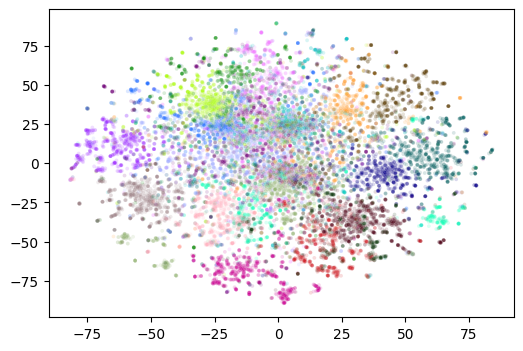

time: 1min 35s (started: 2023-05-28 20:39:31 -07:00)


In [3]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1lu",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[20:41:45] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=250928;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=189705;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5664331953730235, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.052525727191336, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.5499097951820016, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3337068874031625, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.19694400226396405, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6977910255412878, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.6580632511941239, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.614398511455902, info={'metric': 'euclidean', '

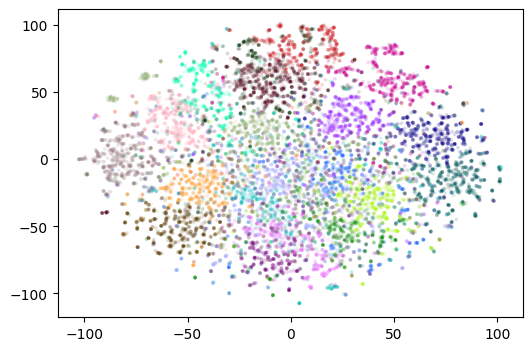

time: 1min 51s (started: 2023-05-28 20:41:44 -07:00)


In [4]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1lr",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l1 norm, sublinear scaling

[20:44:06] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=852819;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=173175;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5090098694683223, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.011403402321927174, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.1761222540592168, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.07941526053273906, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.041239520322614874, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6503904887032691, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.5860385205545908, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5493471326641804, info={'metric': 'euclide

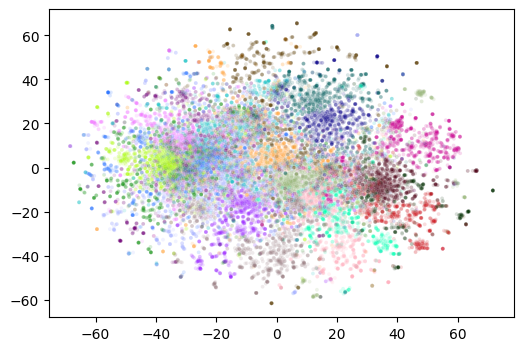

time: 1min 5s (started: 2023-05-28 20:44:05 -07:00)


In [5]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1su",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[20:45:11] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=881508;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=832842;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5501538788071739, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.10323088838170005, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.48795146627047303, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.29830308818847506, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.1876348650465174, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.7461882348300866, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.7208041728603722, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.7019777542839198, info={'metric': 'euclidean

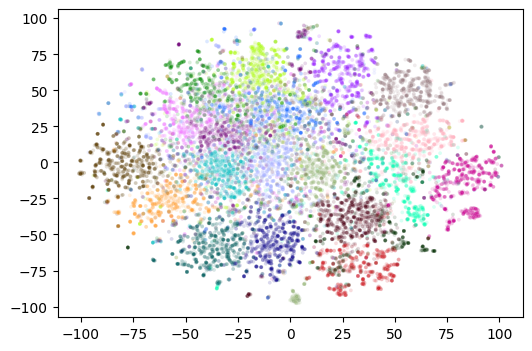

time: 1min 47s (started: 2023-05-28 20:45:11 -07:00)


In [6]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1sr",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l2 norm, linear scaling

[20:47:11] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=68982;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=889587;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5819059747426509, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.2715298502078639, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.3973964413314938, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.20286108458028232, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.10678623226856274, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6504310383565662, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.5697331006831177, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5038477926715285, info={'metric': 'euclidean'

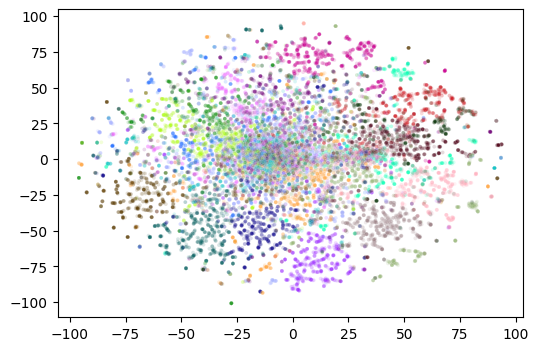

time: 1min 42s (started: 2023-05-28 20:47:11 -07:00)


In [7]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2lu",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[20:48:53] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=340115;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=742693;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5280696168948318, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.12607968594552704, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.5441649863808413, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3419017298100393, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.20175846333439457, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6856050747280609, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.6426617497213095, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.606002848008129, info={'metric': 'euclidean',

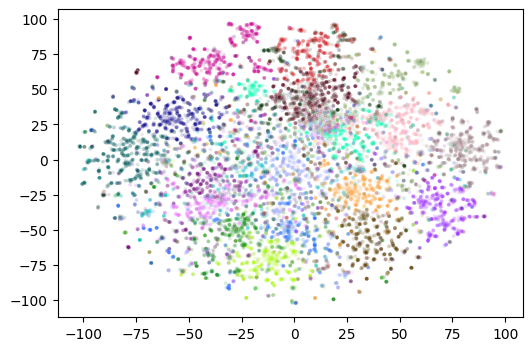

time: 1min 48s (started: 2023-05-28 20:48:53 -07:00)


In [8]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2lr",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l2 norm, sublinear scaling

[20:50:43] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=659450;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=703304;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5905550249389792, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.31218810771796085, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.16713007181011003, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.08130956171070786, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.04435813081467332, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.506344323795335, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.3821977491732697, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.2838520873450211, info={'metric': 'euclidean

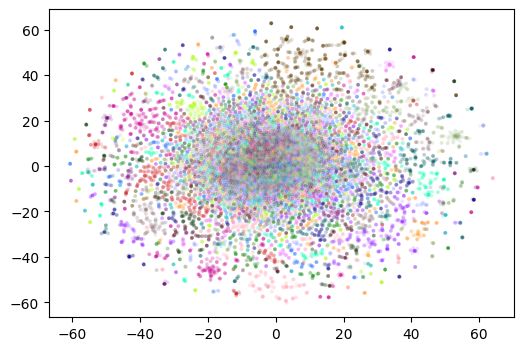

time: 56.8 s (started: 2023-05-28 20:50:42 -07:00)


In [9]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2su",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[20:51:39] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=92454;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=912355;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5277618592804839, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.098844970577021, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.4906540733665853, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3002589408893134, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.18860306342636812, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.737722730361438, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.7090601648123672, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.6772986240985805, info={'metric': 'euclidean', '

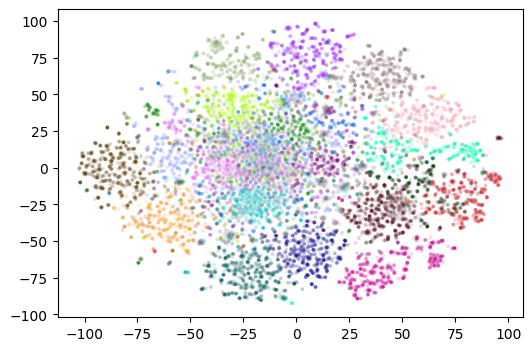

time: 1min 46s (started: 2023-05-28 20:51:39 -07:00)


In [10]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2sr",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## Obviously, rescaling is helpful

Let's pause here and acknowledge that rescaling really seems like a good idea for 20NG. The L2 norm/sublinear scaling result looks *horrible* without rescaling. With rescaling, it's perhaps the best-looking output.

In terms of metrics, rescaling always increases the neighbor preservation *and* the label preservation. It's particularly apparent with sublinear scaling.

# 500 dimensions

Now let's repeat all the above but with SVD that always used 500 components. This is to test whether the rather large number of components I used (~2000) makes the effect of rescaling more apparent.

## l1 norm, linear scaling

[20:53:25] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=260113;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=512675;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5564363790724822, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.13234282897555302, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.40080299975237893, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.2928186352541654, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.18800488167250345, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6383421579316652, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.5839947285167526, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5279040207256993, info={'metric': 'euclidean

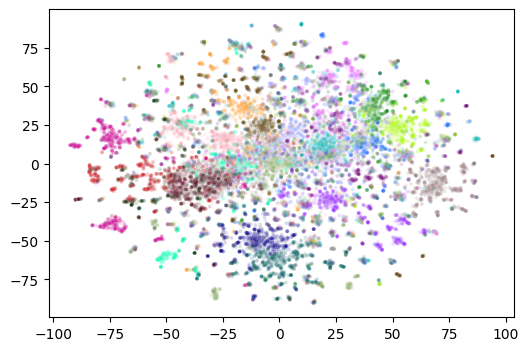

time: 1min 42s (started: 2023-05-28 20:53:25 -07:00)


In [11]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1lu-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[20:55:07] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=264003;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=125039;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5725565106653933, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.0895685719265731, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.5658707418019738, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.4612289079910856, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.31109413138066433, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6501049330245925, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.5922199817578349, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5410267148196449, info={'metric': 'euclidean',

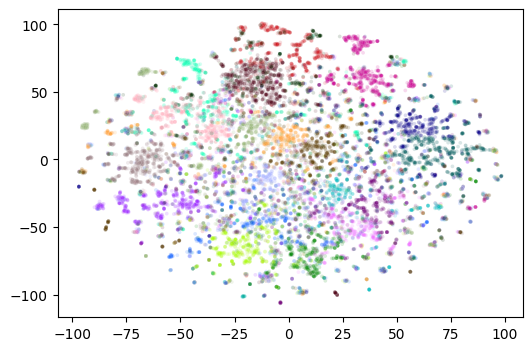

time: 1min 51s (started: 2023-05-28 20:55:07 -07:00)


In [12]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1lr-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l1 norm, sublinear scaling

[20:56:59] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=268027;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=987144;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5395733842725247, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.09421532454300738, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.26649333191835584, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.17792953411864587, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.12084226537903711, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6730475213571588, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.6302864706735803, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5899969422232714, info={'metric': 'euclidea

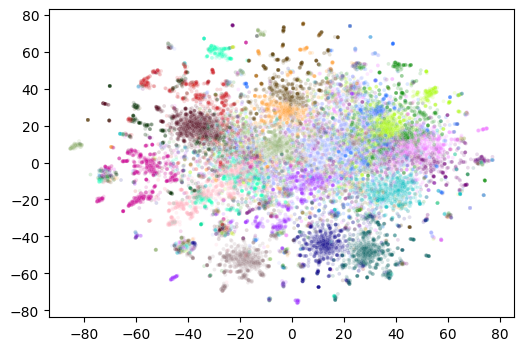

time: 1min 23s (started: 2023-05-28 20:56:58 -07:00)


In [13]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1su-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[20:58:22] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=295659;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=998618;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.574785100286533, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.23308139056592062, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.46430011673564686, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3500084898652234, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.26524602921928614, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.701552858005696, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.6628967213595649, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.6271885862158371, info={'metric': 'euclidean',

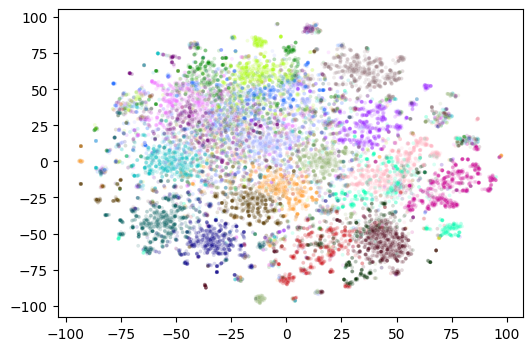

time: 1min 42s (started: 2023-05-28 20:58:22 -07:00)


In [14]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l1sr-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l2 norm, linear scaling

[21:00:04] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=690649;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=3696;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6048392231773321, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.34864852390083395, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.4463794262266087, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.31583572110792746, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.1827418727227705, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6424742126779357, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.572049340420636, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5200950167101068, info={'metric': 'euclidean',

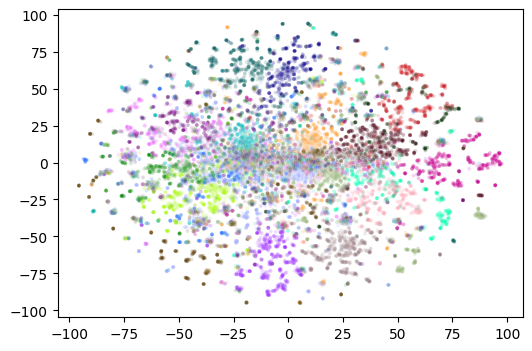

time: 1min 43s (started: 2023-05-28 21:00:04 -07:00)


In [15]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2lu-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[21:01:48] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=121954;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=816676;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5554918815663801, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.20358479948255087, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.5438147794403764, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.45160670699352645, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.29150093742261846, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6706307738914156, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.607240075402946, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.5634557216044398, info={'metric': 'euclidean'

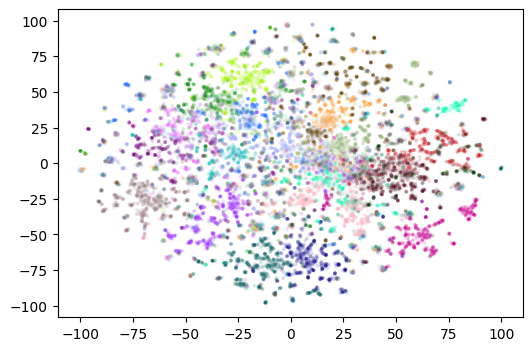

time: 1min 47s (started: 2023-05-28 21:01:47 -07:00)


In [16]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2lr-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l2 norm, sublinear scaling

[21:03:35] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=549835;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=502305;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5959460893558315, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.34460572094135045, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.2762991262513708, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.16907035975803889, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.11163040786727511, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.6034295284688551, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.5200047032224793, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.44316029610560104, info={'metric': 'euclidea

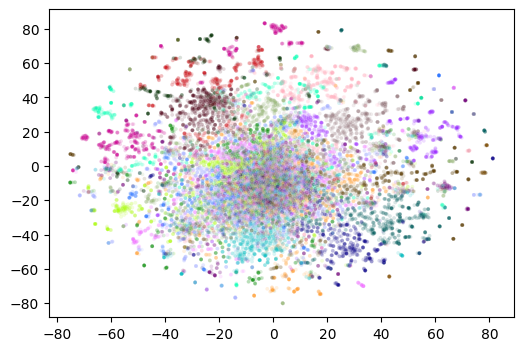

time: 1min 20s (started: 2023-05-28 21:03:34 -07:00)


In [17]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2su-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[21:04:56] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=39410;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=397198;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5639711344582405, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.22195855877627635, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.4588312285542468, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.35109731508012315, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.26243057766457956, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.7109053260513672, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.6661511823936256, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.633111061279026, info={'metric': 'euclidean'

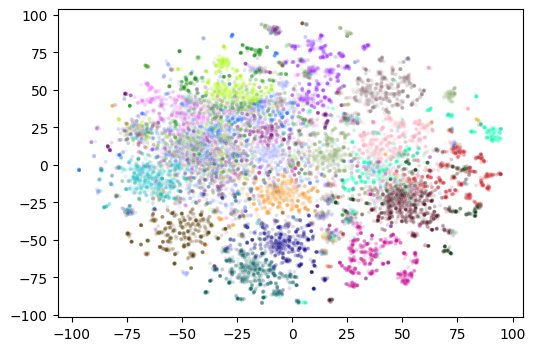

time: 1min 40s (started: 2023-05-28 21:04:55 -07:00)


In [18]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="ng20l2sr-pca500",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## Rescaling still works well

With 500 components, rescaling is also always an improvement in terms of metrics, but the effect is smaller. Sometimes the 500 component result is better than the equivalent larger component result, but if rescaling, usually the ~2000 component result is better than the equivalent 500 component result.

Visually, there is a tendency to create a large number of very small clusters to a greater extent than in the ~2000 component results. I don't think I like it. I'm not sure what makes the "cauliflower"-looking effect show up, but it may be a symptom of too aggressive SVD?

# iclr, 100 components

Let's also take a look at the [iclr abstract data](https://github.com/dkobak/iclr-tsne/blob/main/iclr-tsne.ipynb) originally analyzed by Dmitry Kobak, using L2 norm, sublinear scaling, and SVD with 100 components.

[21:45:56] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=928157;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=119501;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.6060649993959164, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.331994508535394, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.3059482098989167, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3064153678869156, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.33253997019854215, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.2091379805700176, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.20677533677110316, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.18884714648909554, info={'metric': 'euclidean'

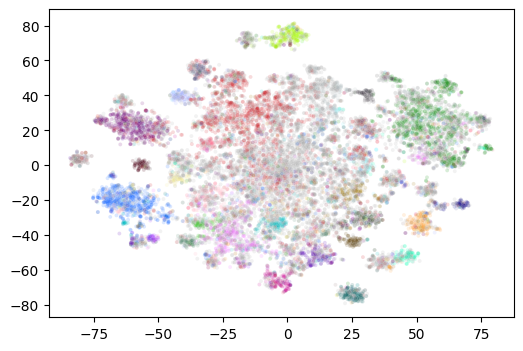

time: 1min 26s (started: 2023-05-28 21:45:56 -07:00)


In [19]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclr",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[21:47:28] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=862765;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=25148;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5915186661833998, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.32310892054374196, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.3657283234666344, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3692195239821191, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.4233550803431196, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.21814945020934706, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.21706771244905904, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.21111501711042033, info={'metric': 'euclidea

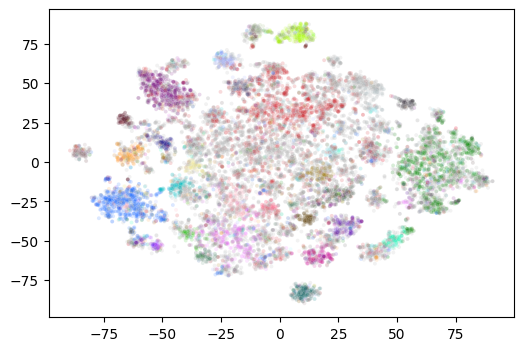

time: 1min 33s (started: 2023-05-28 21:47:28 -07:00)


In [20]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclr-l2r",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

The same pattern with the metrics shows up here. The effect is smaller than with 20NG, but as this only used 100 components in the SVD, that is in line with the effect getting smaller for smaller numbers of components.

# iclr, 200 components

These datasets again use the `iclr` data, but with a more comprehensive variation of norm and scaling, and extract 200 components (anywhere between 100-200 components seemed like a perfectly good choice for every TF-IDF setting I looked at for this dataset). These are also prepared in `tfidf-renorm-prep.ipynb`.

## l1 norm, linear scaling

[22:36:44] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=587973;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=620893;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5771898030687447, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.2419402056669373, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.3329789376182998, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3396230518303734, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.3075200354395715, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.2135743307820346, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.21294490299117166, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.1902464239530909, info={'metric': 'euclidean',

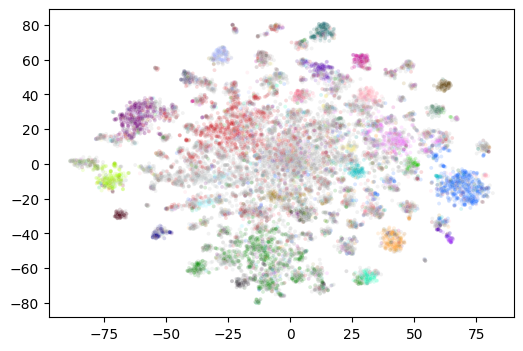

time: 1min 29s (started: 2023-05-28 22:36:43 -07:00)


In [22]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl1lu-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[22:38:22] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=396923;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=655883;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5928114050984656, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3190885002715283, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.4344529016149169, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.48135556361000365, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.4703354677620716, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.22059245327387436, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.21882825044642767, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.1998263515005913, info={'metric': 'euclidean

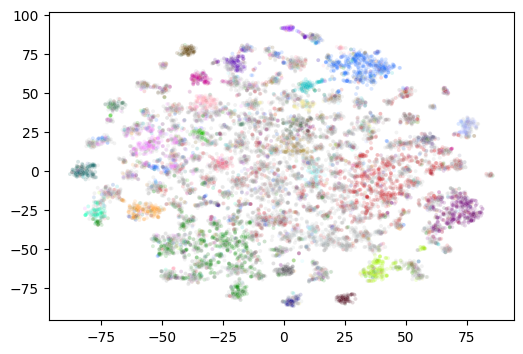

time: 1min 35s (started: 2023-05-28 22:38:22 -07:00)


In [23]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl1lr-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l1 norm, sublinear scaling

[22:39:58] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=524523;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=391925;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5637549836897426, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.16984038860460718, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.254673593492006, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.25508155128669807, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.25800894043735645, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.21479858227504062, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.2147312002899285, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.20684239858825407, info={'metric': 'euclidea

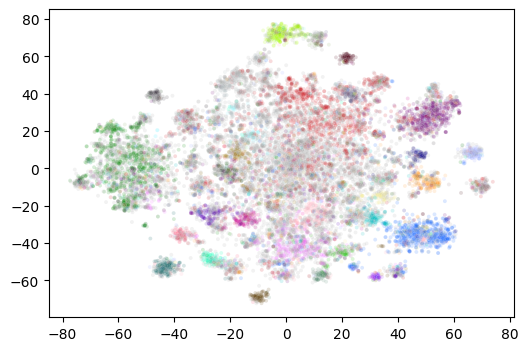

time: 1min 19s (started: 2023-05-28 22:39:58 -07:00)


In [24]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl1su-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[22:41:17] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=248212;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=816321;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5921106681164674, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.33145450329668497, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.37634408602150543, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.3895819741452217, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.41895976803189555, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.21844236409968334, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.21365271853196685, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.20297558075676345, info={'metric': 'euclid

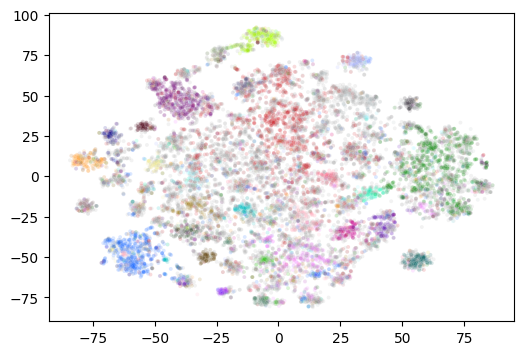

time: 1min 34s (started: 2023-05-28 22:41:17 -07:00)


In [25]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl1sr-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l2 norm, linear scaling

[22:42:51] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=655654;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=888942;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5937900205388427, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.3025952559471919, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.328307357738311, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.33834118642020056, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.3033172244371954, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.21651007593305333, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.21057152366989332, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.19770576681919302, info={'metric': 'euclidean

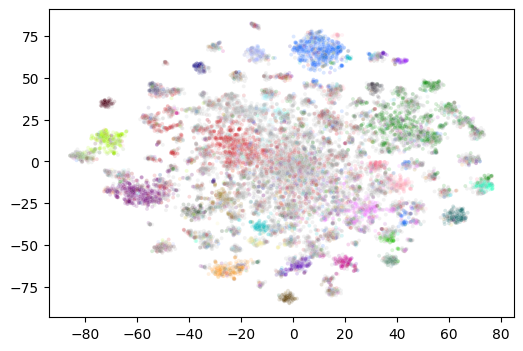

time: 1min 28s (started: 2023-05-28 22:42:51 -07:00)


In [26]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl2lu-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[22:44:20] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=638606;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=606218;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5820707985985261, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.2971170267110159, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.4148564294631711, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.4561290322580645, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.45630743828279163, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.22569069998224428, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.22404875302746277, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.20393000033480935, info={'metric': 'euclidea

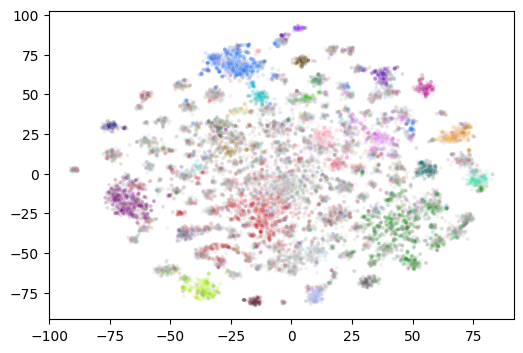

time: 1min 38s (started: 2023-05-28 22:44:20 -07:00)


In [27]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl2lr-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

## l2 norm, sublinear scaling

[22:45:59] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=405139;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=546260;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5889935967137853, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.2736220807908181, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.27337602190809873, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.2698888486166486, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.2702057911481615, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.2121351780393889, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.21527373313441278, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.20395534637247736, info={'metric': 'euclidean

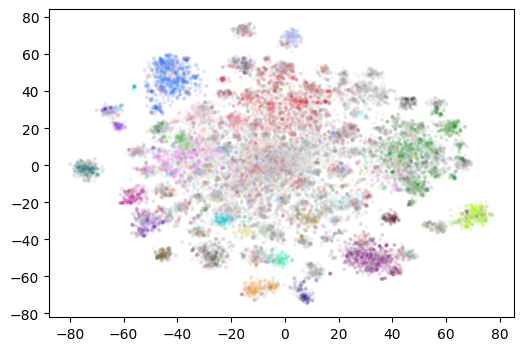

time: 1min 20s (started: 2023-05-28 22:45:59 -07:00)


In [28]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl2su-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

[22:47:19] INFO     KNN index provided. Ignoring KNN-related parameters.                           ]8;id=234812;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py\affinity.py]8;;\:]8;id=955794;file:///home/james/dev/drnb/venv/lib/python3.10/site-packages/openTSNE/affinity.py#1175\1175]8;;\

[EvalResult(eval_type='RTE', label='rte-5-euclidean', value=0.5758245741210584, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='RPC', label='rpc-5-euclidean', value=0.26959242498733316, info={'metric': 'euclidean', 'ntpp': 5}),
 EvalResult(eval_type='NNP', label='nnp-15-noself-euclidean', value=0.366465305464943, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='NNP', label='nnp-50-noself-euclidean', value=0.37794007490636705, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='NNP', label='nnp-150-noself-euclidean', value=0.4124791591156216, info={'metric': 'euclidean', 'n_neighbors': 150}),
 EvalResult(eval_type='LP', label='lpb-15', value=0.21699704004435666, info={'metric': 'euclidean', 'n_neighbors': 15}),
 EvalResult(eval_type='LP', label='lpb-50', value=0.21774298253014818, info={'metric': 'euclidean', 'n_neighbors': 50}),
 EvalResult(eval_type='LP', label='lpb-150', value=0.20918708041937145, info={'metric': 'euclidea

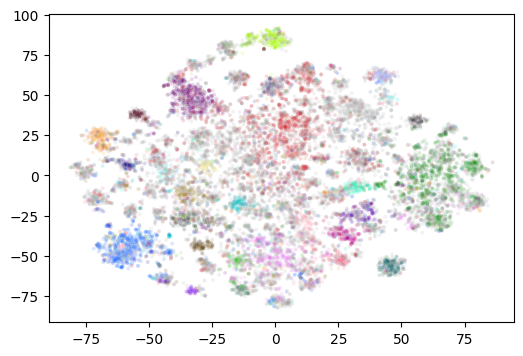

time: 1min 31s (started: 2023-05-28 22:47:19 -07:00)


In [29]:
pl.standard_eval(
    method=("tsne", dict(affinity="uniform", n_neighbors=10, anneal_exaggeration=True)),
    dataset="iclrl2sr-pca200",
    extra_eval=[("lp", dict(n_neighbors=[15, 50, 150]))],
)

The metrics show a similar pattern to 20NG: rescaling always improves the neighbor preservation and the label preservation, although in the latter case not by very much at all. Sublinear scaling seems to make it harder to preserve neighbors in the low dimensional space. Visually, the effect of rescaling seems to be to create more, smaller clusters, but that also seems to be because without rescaling, there seems to a be a larger density of unclustered points in the middle of the plot.

# What have we learned?

* If doing dimensionality reduction on the output of TF-IDF+SVD, then rescaling to L1/L2 norm is a good idea visually, and the preservation metrics appear to confirm that.
* The metrics seem to point to setting `sublinear=False` as making it easier to faithfully layout the data in 2D. But it did seem to produce a bit more clustering in the output.
* I really couldn't say whether L1 or L2 norm makes much difference.
